# 'Presidential' Meme Search Engine

## Still to do:

improve speed if possible

use all data to make plot of emotion data over time

In [256]:
# IMPORT VARIOUS LIBRARIES
import pandas as pd
import datetime
import urllib2
from IPython.display import display
from pyparsing import makeHTMLTags, withAttribute, Optional, Group
from IPython.core.display import HTML
from difflib import SequenceMatcher
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import indicoio
indicoio.config.api_key = 'b669130e3e1d07909794d8e5b7a6b11e'

In [229]:
# original import data DONT RUN ANYMORE
'''trump = pd.read_csv("data/merged.csv", index_col=["id"],
        usecols=["id", "caption", "likes", "network", "link","timestamp"], 
                    dtype={"id": int, "caption": str,"link":str, "likes": int, "network":str, "timestamp":str})'''
# nrows=10 # limit read csv rows read
#list(trump.columns.values) # used to list columns
wordCount = 0
rowCount = 0
#trump.drop_duplicates(subset='caption', keep='last') #get rid of identical captions
def clean():
    wCount = 0
    rCount = 0
    for index, row in trump.iterrows():
        row["caption"] = row["caption"].replace("\\n", "")
        row["caption"] = row["caption"].lower()
        wCount += len(row["caption"].split())
        rCount += 1
        trump.set_value(index, "caption", row["caption"])
        trump.set_value(index, "timestamp", datetime.datetime.strptime(row["timestamp"], "%m/%d/%y %H:%M"))
    info = {}
    info["words"] = wCount # total number of words
    info["rows"] = rCount # number of rows
    info["avgWords"] = wCount / rCount # ang words in each document
    return info

#info = clean()
#trump.to_csv("data/clean.csv")
print("Done")

Done


In [230]:
# run to get data into python/notebook

class qResults: # class for query results
    def __init__(self, caption, network, likes, link, timestamp):
        self.caption = caption
        self.link = link
        self.network = network
        self.likes = likes
        self.score = 0
        self.timestamp = timestamp
        
def getInfo():
    wCount = 0
    rCount = 0
    for index, row in trump.iterrows():
        wCount += len(row["caption"].split())
        rCount += 1
    info = {}
    info["words"] = wCount # total number of words
    info["rows"] = rCount # number of rows
    info["avgWords"] = wCount / rCount # ang words in each document
    return info
# read already cleaned dataset
trump = pd.read_csv("data/clean.csv", index_col=["id"], 
        usecols=["id", "caption", "likes", "network", "link","timestamp"], 
                    dtype={"id": int, "caption": str,"link":str, "likes": int, "network":str, "timestamp":str})
info = getInfo() # get some basic info on dataframe


In [231]:
#facebook script for display of memes
htmlScript = """<div id="fb-root"></div>
<script>(function(d, s, id) {
  var js, fjs = d.getElementsByTagName(s)[0];
  if (d.getElementById(id)) return;
  js = d.createElement(s); js.id = id;
  js.src = "//connect.facebook.net/en_US/sdk.js#xfbml=1&version=v2.8";
  fjs.parentNode.insertBefore(js, fjs);
}(document, 'script', 'facebook-jssdk'));</script>"""
htmlScr = HTML(htmlScript)
display(htmlScr)

In [252]:
def search(query):
    global trump # dataframe of memes
    results = [] # list for results
    qFrequency = {} # dictionary for frequency of each word in query
    query = query.lower() # make consistent
    if len(query.split()) > 1: # query has two or more words
        
        for qry in qSplit:
            qFrequency[qry] = 0
    else:
        qFrequency[query] = 0
    qSplit = query.split() # split into each word
    for index, row in trump.iterrows():
        if len(query.split()) > 0: # query has two or more words
            allFound = True # all words query must be present to keep
            for qry in qSplit: # go through each word in query string
                if qry in row["caption"]:
                    qFrequency[qry] += row["caption"].count(qry) # increment frequency of word in dataset       
                else:
                    allFound = False; # skip, not all words in query found
            if allFound is True:
                newResult = qResults(row["caption"], row["network"], row["likes"], row["link"], row["timestamp"])
                results.append(newResult) 
    res = {} # init dict to return
    res["rows"] = results # each results in a list
    res["qf"] = qFrequency # frequency of terms in a dictionary
    return res

def printResults(results, limit):
    count = 0
    htmlStr = "<html><body>" # begin html string
    style = "style=\"width:50%;\" " # for images formatting
    for r in results:
        if count >= limit: #stop after limit
            break
        else:
            if r.network == "instagram":
                tempurl = "https://www.{0}/".format(r.link[8:len(r.link)])
                try:
                    response = urllib2.urlopen(tempurl) # check if exists
                    html = response.read()
                    meta,metaEnd = makeHTMLTags("meta")
                    img_meta = meta.copy().setParseAction(withAttribute(('property','og:image'))) # get image
                    htmlStr += '<p>Score: ' + str(r.score) + " url: " + r.link + '</p>'
                    #htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'
                    
                    htmlStr += "<img " + style + "src='" + img_meta.searchString(html)[0].content + "'>" # show images
                    
                except:
                    """htmlStr += '<br><p>Instagram Image Not Found :(<br>'
                    htmlStr += '<p>Score: ' + str(r.score) + " url: " + r.link + '</p>'
                    htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'"""
                    limit += 1
            elif r.network == "imgur":
                tempurl = r.link
                try:
                    response = urllib2.urlopen(tempurl) # check if link is valid
                    html = response.read()
                    meta,metaEnd = makeHTMLTags("meta")
                    img_meta = meta.copy().setParseAction(withAttribute(('name','twitter:image'))) # find image
                    htmlStr += '<p>Score: ' + str(r.score) + " url: " + r.link + '</p>'
                    htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'
                    htmlStr += "<img " + style + "src='" + img_meta.searchString(html)[0].content + "'>" # show images
                except:
                    """htmlStr += '<br><p>Imgur Image Not Found :(<br>'
                    htmlStr += '<p>Score: ' + str(r.score) + " url: " + r.link + '</p>'
                    htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'"""
                    limit += 1

            elif r.network == "facebook":
                try:
                    response = urllib2.urlopen(r.link) # check if link is valid
                    htmlStr += '<p>Score: ' + str(r.score) + " url: " + r.link + '</p>'
                    #htmlStr += '<p>Date: ' + str(r.timestamp) + " caption: " + r.caption + '</p>'
                    htmlStr += """<div class="fb-post" data-href="{0}" 
                    data-width="500" data-show-text="true"><blockquote cite="{0}" 
                    class="fb-xfbml-parse-ignore">Posted by <a href="https://www.facebook.com/facebook/">Facebook</a> on&nbsp;
                    <a href="{0}">{1}</a>
                    </blockquote></div>""".format(r.link, str(r.timestamp))
                except:
                    limit += 1
                            
        count += 1
    htmlStr += "</body></html>" # end html
    html = HTML(htmlStr) 
    display(html) # show html
    
def similar(a, b): # check similarity of two strings
    return SequenceMatcher(None, a, b).ratio()

def getScores(results, info):
    # BM25 Variables
    k = 1.2
    b = .75
    for r in results["rows"]:
        r.score = 0
        if r.network == "imgur" or r.network == "instagram" or r.network == "facebook":
        #if r.network == "imgur" or r.network == "instagram": # witout facebook
            for q in results["qf"]: # give bm25 based score
                fqd = r.caption.count(q)
                tempScore = ((fqd * (k + 1) / (fqd + k * (1 - b + b * len(r.caption) / info["avgWords"]))))
                tempScore *= (info["rows"] - results["qf"][q] + .5) / (results["qf"][q] + .5)
                likeScore = r.likes * .1
                maxLikeInfluence = 10
                if likeScore > maxLikeInfluence:
                    likeScore = maxLikeInfluence
                elif likeScore < -maxLikeInfluence:
                    likeScore = -maxLikeInfluence
                tempScore += likeScore
                r.score += tempScore
    return results

def noDuplicates(results, limit):
    count = 0
    dupFree = [] # no caption duplicates
    index = 0
    dupFree.append(results["rows"][index]) # add first to list
    index += 1
    dupLimit = limit * 1.5 # get extra in case links are dead
    if dupLimit > len(results["rows"]):
        dupLimit = len(results["rows"])
    while len(dupFree) < dupLimit and index < len(results["rows"]):
        dupFound = False # catch if similar caption found
        for i in dupFree:
            if similar(i.caption, results["rows"][index].caption) > .8: # checks similarity
                dupFound = True # duplicate found, don't add
        if dupFound == False:
            dupFree.append(results["rows"][index]) # not a dup, add it
        index += 1
    return dupFree

In [251]:
# SEARCH HERE
query = "locker"

results=search(query)  # get results
results = getScores(results, info)
results["rows"] = sorted(results["rows"],key=lambda qResults: qResults.score, reverse=True)
limit = 10
dupFree = noDuplicates(results, limit)

printResults(dupFree, limit)


Done


In [253]:
timeResults = sorted(results["rows"],key=lambda qResults: qResults.timestamp, reverse=True)

indicoCaptions = []
count = 0
for tRes in timeResults:
    if count % 2 == 0: # add every 2 (or however many)
        try:
            indicoCaptions.append(tRes.caption.encode(encoding='UTF-8',errors='strict'))
        except:
            nothing = 0 # do nothing ** for indent
    count += 1
#sent = indicoio.sentiment(indicoCaptions)

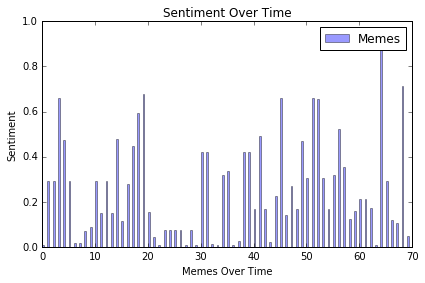

Results: 139 from: 2016-10-28 17:29:00 to: 2016-05-14 02:43:00


In [255]:
n_groups = len(sent)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
    
rects1 = plt.bar(index, sent, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Memes')


plt.xlabel('Memes Over Time')
plt.ylabel('Sentiment')
plt.title('Sentiment Over Time')
plt.legend()
plt.tight_layout()
plt.show()
showInfo = "Results: " + str(len(timeRes)) + " from: "
showInfo += timeRes[0].timestamp + " to: " + timeRes[countBlah-1].timestamp
print(showInfo)